# LSTM Modelling 

In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

2023-05-17 11:18:09.156656: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-17 11:18:09.184425: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-17 11:18:09.185453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 11:18:09.845123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Refactor

In [2]:
dataset = pd.read_csv("../StationDateDatasets/datasetStationDate.csv").drop(columns=["Unnamed: 0"])

In [ ]:
trips = pd.read_csv("../CSVFiles/datatrips.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips = trips.drop(columns=["DateEnd"])
trips["Day"] = day
trips["Year"] = year

In [ ]:
new_data = pd.DataFrame({"Holiday": [], "Weekday": [], "Workingday": [], "WeatherSituation": [], "Temp": [], "ATemp": [], "Humidity": [], "Windspeed": []})

for data in dataset.values:
    hour = data[0]
    station = data[1]
    day = data[3]
    year = data[4]

    df = trips.loc[(trips["StationEnd"] == station) & (trips["Day"] == day) & (trips["Year"] == year) & (trips["Hour"] == hour)].values[0][6:-1]
    new_data.loc[len(new_data)] = df

dataset = dataset.join(new_data)

In [11]:
dataset.to_csv("../StationDateDatasets/datasetStationDate.csv")

## Correlation Features

In [12]:
def featureSelect_dataframe(X, y, criteria, k):

    # initialize our function/method
    reg = SelectKBest(criteria, k=k).fit(X,y)
    
    # transform after creating the reg (so we can use getsupport)
    X_transformed = reg.transform(X)

    # filter down X based on kept columns
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    # return that dataframe
    return X, reg.scores_

X = dataset[[col for col in dataset.columns if "Count" not in col]]
y = dataset['Count']

new_x_data = []

# F-value between label/feature for regression tasks.
New_X, scoresX = featureSelect_dataframe(X, y, f_regression, 11)
new_x_data_1 = {list(X.columns)[x]:scoresX[x] for x in range(0,len(list(X.columns)))}
pprint(sorted(new_x_data_1.items(), key=lambda x:x[1], reverse=True))

[('Temp', 7854.233184039789),
 ('ATemp', 7706.912809130377),
 ('Year', 5350.628642028699),
 ('Humidity', 5196.287790444266),
 ('Hour', 2591.040359724638),
 ('WeatherSituation', 1576.8091838740354),
 ('Windspeed', 261.06541187993037),
 ('Day', 225.13003715150458),
 ('StationEnd', 215.19085620330532),
 ('Workingday', 72.2059928262909),
 ('Holiday', 60.46833284115195),
 ('Weekday', 48.945415173314345)]


## LSTM

In [17]:
epochs = 1
batch_size = 1
verbose = 2

MSE = [4.15470335483551, 4.093192148208618, 6.351857042312622, 6.353482866287232, 6.34966082572937, 6.3501441955566404, 4.002523446083069, 4.0913327693939205, 3.7415821313858033, 3.6985947132110595]

### Method 0
Input: c(t), StationEnd

Output: c(t+1)

In [14]:
cols = ["StationEnd", "Day", "Count", "Count1", "Count1week", "Count2week", "Count3week"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-17 09:36:03.885049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 09:36:03.891905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 09:36:03.893387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 178s - loss: 4.6209 - accuracy: 0.3328 - 178s/epoch - 974us/step


2023-05-17 09:39:02.700492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 09:39:02.701502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 09:39:02.702364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 170s - loss: 4.1473 - accuracy: 0.3334 - 170s/epoch - 927us/step
183062/183062 - 164s - loss: 4.1290 - accuracy: 0.3339 - 164s/epoch - 894us/step
183063/183063 - 169s - loss: 4.1066 - accuracy: 0.3336 - 169s/epoch - 925us/step
183063/183063 - 170s - loss: 4.1083 - accuracy: 0.3332 - 170s/epoch - 926us/step
183063/183063 - 170s - loss: 4.1107 - accuracy: 0.3348 - 170s/epoch - 927us/step
183063/183063 - 169s - loss: 4.1058 - accuracy: 0.3343 - 169s/epoch - 921us/step
183063/183063 - 169s - loss: 4.1138 - accuracy: 0.3340 - 169s/epoch - 924us/step
183063/183063 - 173s - loss: 4.0921 - accuracy: 0.3336 - 173s/epoch - 944us/step
183063/183063 - 175s - loss: 4.1343 - accuracy: 0.3343 - 175s/epoch - 957us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.06172513961792 - Accuracy: 33.282533288002014%
--------------------------------------------

Text(0.5, 0, 'Methods')

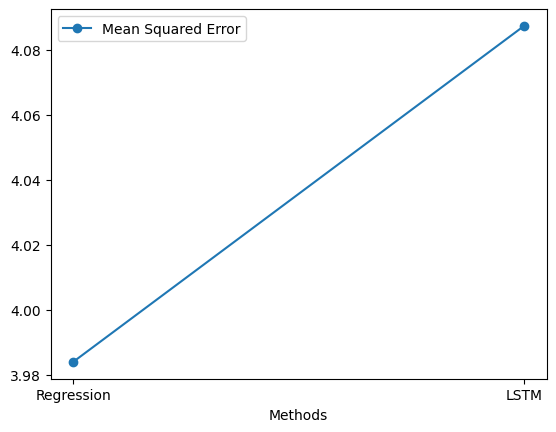

In [22]:
plt.plot(["Regression", "LSTM"], [3.9839102446556587, 4.087373924255371], marker="o")
plt.legend(["Mean Squared Error"])
plt.xlabel("Methods")

### Method 1
Input: ..., Temp

Output: c(t+1)

In [16]:
cols = ["StationEnd", "Day", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-05-17 10:16:26.370558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 10:16:26.371571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 10:16:26.372210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 166s - loss: 4.5489 - accuracy: 0.3338 - 166s/epoch - 909us/step


2023-05-17 10:19:12.983229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 10:19:12.984355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 10:19:12.985007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 170s - loss: 4.1974 - accuracy: 0.3335 - 170s/epoch - 928us/step
183062/183062 - 168s - loss: 4.1773 - accuracy: 0.3340 - 168s/epoch - 918us/step
183063/183063 - 169s - loss: 4.1809 - accuracy: 0.3335 - 169s/epoch - 922us/step
183063/183063 - 169s - loss: 4.1662 - accuracy: 0.3339 - 169s/epoch - 922us/step
183063/183063 - 172s - loss: 4.1507 - accuracy: 0.3330 - 172s/epoch - 939us/step
183063/183063 - 171s - loss: 4.1448 - accuracy: 0.3340 - 171s/epoch - 936us/step
183063/183063 - 170s - loss: 4.0959 - accuracy: 0.3342 - 170s/epoch - 931us/step
183063/183063 - 170s - loss: 4.1315 - accuracy: 0.3342 - 170s/epoch - 930us/step
183063/183063 - 172s - loss: 4.1379 - accuracy: 0.3340 - 172s/epoch - 939us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.414585113525391 - Accuracy: 32.874488830566406%
-------------------------------------------

### Method 2
Input: ..., Temp, ATemp

Output: c(t+1)

In [17]:
cols = ["StationEnd", "Day", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-05-17 10:44:48.670204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 10:44:48.671198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 10:44:48.671837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 175s - loss: 4.5103 - accuracy: 0.3343 - 175s/epoch - 957us/step


2023-05-17 10:47:44.049844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 10:47:44.050701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 10:47:44.051574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 174s - loss: 4.1796 - accuracy: 0.3339 - 174s/epoch - 952us/step
183062/183062 - 187s - loss: 4.1554 - accuracy: 0.3342 - 187s/epoch - 1ms/step
183063/183063 - 172s - loss: 4.1387 - accuracy: 0.3338 - 172s/epoch - 937us/step
183063/183063 - 171s - loss: 4.1511 - accuracy: 0.3334 - 171s/epoch - 935us/step
183063/183063 - 171s - loss: 4.1089 - accuracy: 0.3336 - 171s/epoch - 936us/step
183063/183063 - 172s - loss: 4.1084 - accuracy: 0.3339 - 172s/epoch - 938us/step
183063/183063 - 170s - loss: 4.1365 - accuracy: 0.3344 - 170s/epoch - 928us/step
183063/183063 - 172s - loss: 4.1051 - accuracy: 0.3340 - 172s/epoch - 940us/step
183063/183063 - 170s - loss: 4.1489 - accuracy: 0.3337 - 170s/epoch - 929us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.114871501922607 - Accuracy: 33.066222071647644%
---------------------------------------------

### Method 3
Input: ..., Temp, ATemp, Year

Output: c(t+1)

In [5]:
cols = ["StationEnd", "Day", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Year"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-05-17 11:41:37.185752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 11:41:37.187154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 11:41:37.187893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 153s - loss: 6.4565 - accuracy: 0.3315 - 153s/epoch - 837us/step


2023-05-17 11:44:10.642352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 11:44:10.643186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 11:44:10.644090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 146s - loss: 6.3542 - accuracy: 0.3336 - 146s/epoch - 797us/step
183062/183062 - 146s - loss: 6.3629 - accuracy: 0.3342 - 146s/epoch - 795us/step
183063/183063 - 141s - loss: 6.3584 - accuracy: 0.3339 - 141s/epoch - 773us/step
183063/183063 - 139s - loss: 6.3496 - accuracy: 0.3339 - 139s/epoch - 759us/step
183063/183063 - 140s - loss: 6.3138 - accuracy: 0.3342 - 140s/epoch - 763us/step
183063/183063 - 142s - loss: 6.3469 - accuracy: 0.3337 - 142s/epoch - 774us/step
183063/183063 - 140s - loss: 6.3614 - accuracy: 0.3340 - 140s/epoch - 765us/step
183063/183063 - 141s - loss: 6.3411 - accuracy: 0.3341 - 141s/epoch - 771us/step
183063/183063 - 156s - loss: 6.3698 - accuracy: 0.3338 - 156s/epoch - 850us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 6.315084457397461 - Accuracy: 33.5725873708725%
---------------------------------------------

### Method 4
Input: ..., Temp, ATemp, Year, Humidity

Output: c(t+1)

In [6]:
cols = ["StationEnd", "Day", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Year", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-05-17 12:05:44.987110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 12:05:44.988702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 12:05:44.989454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 151s - loss: 6.4151 - accuracy: 0.3328 - 151s/epoch - 823us/step


2023-05-17 12:08:16.142614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 12:08:16.144697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 12:08:16.145861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 157s - loss: 6.3507 - accuracy: 0.3337 - 157s/epoch - 856us/step
183062/183062 - 147s - loss: 6.3225 - accuracy: 0.3349 - 147s/epoch - 801us/step
183063/183063 - 150s - loss: 6.4015 - accuracy: 0.3340 - 150s/epoch - 821us/step
183063/183063 - 147s - loss: 6.3260 - accuracy: 0.3340 - 147s/epoch - 804us/step
183063/183063 - 159s - loss: 6.3477 - accuracy: 0.3337 - 159s/epoch - 869us/step
183063/183063 - 163s - loss: 6.3636 - accuracy: 0.3335 - 163s/epoch - 892us/step
183063/183063 - 162s - loss: 6.3373 - accuracy: 0.3338 - 162s/epoch - 882us/step
183063/183063 - 158s - loss: 6.3490 - accuracy: 0.3337 - 158s/epoch - 865us/step
183063/183063 - 159s - loss: 6.3612 - accuracy: 0.3337 - 159s/epoch - 866us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 6.331716537475586 - Accuracy: 33.238285779953%
----------------------------------------------

### Method 5
Input: ..., Temp, ATemp, Year, Humidity, Hour

Output: c(t+1)

In [7]:
cols = ["StationEnd", "Day", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Year", "Humidity", "Hour"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-05-17 12:31:42.457233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 12:31:42.458460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 12:31:42.459160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 163s - loss: 6.4243 - accuracy: 0.3325 - 163s/epoch - 888us/step


2023-05-17 12:34:25.326381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 12:34:25.327567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 12:34:25.328203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 161s - loss: 6.3545 - accuracy: 0.3341 - 161s/epoch - 879us/step
183062/183062 - 159s - loss: 6.3402 - accuracy: 0.3342 - 159s/epoch - 870us/step
183063/183063 - 159s - loss: 6.3478 - accuracy: 0.3338 - 159s/epoch - 871us/step
183063/183063 - 158s - loss: 6.3575 - accuracy: 0.3336 - 158s/epoch - 864us/step
183063/183063 - 156s - loss: 6.3715 - accuracy: 0.3336 - 156s/epoch - 855us/step
183063/183063 - 148s - loss: 6.3496 - accuracy: 0.3341 - 148s/epoch - 807us/step
183063/183063 - 147s - loss: 6.3420 - accuracy: 0.3339 - 147s/epoch - 802us/step
183063/183063 - 148s - loss: 6.3462 - accuracy: 0.3336 - 148s/epoch - 810us/step
183063/183063 - 161s - loss: 6.3521 - accuracy: 0.3342 - 161s/epoch - 878us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 6.430745601654053 - Accuracy: 33.277615904808044%
-------------------------------------------

### Method 6
Input: ..., Temp, ATemp, Year, Humidity, Hour, WeatherSituation

Output: c(t+1)

In [10]:
cols = ["StationEnd", "Day", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Year", "Humidity", "Hour", "WeatherSituation"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-05-17 13:03:31.791010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 13:03:31.792086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 13:03:31.792796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 160s - loss: 6.4250 - accuracy: 0.3327 - 160s/epoch - 875us/step


2023-05-17 13:06:12.234289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 13:06:12.235472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 13:06:12.236120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 156s - loss: 6.3384 - accuracy: 0.3341 - 156s/epoch - 853us/step
183062/183062 - 155s - loss: 6.3636 - accuracy: 0.3342 - 155s/epoch - 845us/step
183063/183063 - 146s - loss: 6.3337 - accuracy: 0.3340 - 146s/epoch - 799us/step
183063/183063 - 151s - loss: 6.3918 - accuracy: 0.3342 - 151s/epoch - 825us/step
183063/183063 - 151s - loss: 6.3526 - accuracy: 0.3338 - 151s/epoch - 826us/step
183063/183063 - 154s - loss: 6.3283 - accuracy: 0.3340 - 154s/epoch - 839us/step
183063/183063 - 148s - loss: 6.3414 - accuracy: 0.3335 - 148s/epoch - 808us/step
183063/183063 - 144s - loss: 6.3604 - accuracy: 0.3335 - 144s/epoch - 785us/step
183063/183063 - 142s - loss: 6.3245 - accuracy: 0.3344 - 142s/epoch - 778us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 6.191244125366211 - Accuracy: 33.724987506866455%
-------------------------------------------

### Method 7
Input: ..., Temp, ATemp, Humidity, Hour, WeatherSituation

Output: c(t+1)

In [11]:
cols = ["StationEnd", "Day", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Humidity", "Hour", "WeatherSituation"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-05-17 13:28:43.258811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 13:28:43.259550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 13:28:43.260364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 139s - loss: 4.3552 - accuracy: 0.3338 - 139s/epoch - 761us/step


2023-05-17 13:31:02.839033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 13:31:02.839767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 13:31:02.840545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 140s - loss: 4.0540 - accuracy: 0.3331 - 140s/epoch - 764us/step
183062/183062 - 139s - loss: 4.0567 - accuracy: 0.3339 - 139s/epoch - 761us/step
183063/183063 - 138s - loss: 4.0517 - accuracy: 0.3343 - 138s/epoch - 753us/step
183063/183063 - 138s - loss: 4.0386 - accuracy: 0.3339 - 138s/epoch - 754us/step
183063/183063 - 138s - loss: 4.0208 - accuracy: 0.3339 - 138s/epoch - 755us/step
183063/183063 - 144s - loss: 4.0395 - accuracy: 0.3343 - 144s/epoch - 788us/step
183063/183063 - 147s - loss: 4.0480 - accuracy: 0.3345 - 147s/epoch - 805us/step
183063/183063 - 150s - loss: 4.0284 - accuracy: 0.3334 - 150s/epoch - 820us/step
183063/183063 - 145s - loss: 4.0584 - accuracy: 0.3338 - 145s/epoch - 790us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.114148139953613 - Accuracy: 33.47918093204498%
--------------------------------------------

### Method 8
Input: ..., Temp, ATemp, Humidity, Hour, WeatherSituation -> without StationEnd

Output: c(t+1)

In [14]:
cols = ["Day", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Humidity", "Hour", "WeatherSituation"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-05-17 13:53:24.578442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 13:53:24.579234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 13:53:24.580056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 167s - loss: 4.4584 - accuracy: 0.3337 - 167s/epoch - 915us/step


2023-05-17 13:56:12.301316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 13:56:12.303172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 13:56:12.304487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 159s - loss: 4.1291 - accuracy: 0.3336 - 159s/epoch - 870us/step
183062/183062 - 156s - loss: 4.0604 - accuracy: 0.3338 - 156s/epoch - 851us/step
183063/183063 - 157s - loss: 4.0072 - accuracy: 0.3338 - 157s/epoch - 855us/step
183063/183063 - 156s - loss: 4.1146 - accuracy: 0.3344 - 156s/epoch - 852us/step
183063/183063 - 157s - loss: 4.1155 - accuracy: 0.3340 - 157s/epoch - 860us/step
183063/183063 - 158s - loss: 4.0594 - accuracy: 0.3338 - 158s/epoch - 863us/step
183063/183063 - 158s - loss: 4.0532 - accuracy: 0.3339 - 158s/epoch - 864us/step
183063/183063 - 156s - loss: 4.0589 - accuracy: 0.3337 - 156s/epoch - 854us/step
183063/183063 - 152s - loss: 4.0487 - accuracy: 0.3342 - 152s/epoch - 832us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.1437153816223145 - Accuracy: 33.46443176269531%
-------------------------------------------

### Method 9
Input: ..., Temp, ATemp, Humidity, Hour, WeatherSituation -> without Day

Output: c(t+1)

In [15]:
cols = ["StationEnd", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Humidity", "Hour", "WeatherSituation"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-05-17 14:19:46.742664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 14:19:46.743806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 14:19:46.744568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 151s - loss: 3.9762 - accuracy: 0.3335 - 151s/epoch - 826us/step


2023-05-17 14:22:18.137095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 14:22:18.138329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 14:22:18.139243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 160s - loss: 3.7848 - accuracy: 0.3335 - 160s/epoch - 876us/step
183062/183062 - 155s - loss: 3.7662 - accuracy: 0.3332 - 155s/epoch - 845us/step
183063/183063 - 158s - loss: 3.7598 - accuracy: 0.3347 - 158s/epoch - 863us/step
183063/183063 - 160s - loss: 3.7673 - accuracy: 0.3340 - 160s/epoch - 872us/step
183063/183063 - 158s - loss: 3.7559 - accuracy: 0.3337 - 158s/epoch - 865us/step
183063/183063 - 159s - loss: 3.7369 - accuracy: 0.3343 - 159s/epoch - 870us/step
183063/183063 - 159s - loss: 3.7292 - accuracy: 0.3339 - 159s/epoch - 867us/step
183063/183063 - 160s - loss: 3.7430 - accuracy: 0.3334 - 160s/epoch - 873us/step
183063/183063 - 161s - loss: 3.7434 - accuracy: 0.3341 - 161s/epoch - 877us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 3.8052978515625 - Accuracy: 33.45459997653961%
----------------------------------------------

### Method 10
Input: ..., Temp, ATemp, Humidity, Hour, WeatherSituation -> without StationEnd and Day

Output: c(t+1)

In [16]:
cols = ["Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Humidity", "Hour", "WeatherSituation"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-05-17 14:46:12.347929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 14:46:12.349470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 14:46:12.350512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 156s - loss: 3.9255 - accuracy: 0.3328 - 156s/epoch - 850us/step


2023-05-17 14:48:48.163442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 14:48:48.164493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 14:48:48.165116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 154s - loss: 3.7286 - accuracy: 0.3339 - 154s/epoch - 844us/step
183062/183062 - 156s - loss: 3.7072 - accuracy: 0.3344 - 156s/epoch - 850us/step
183063/183063 - 155s - loss: 3.6920 - accuracy: 0.3337 - 155s/epoch - 849us/step
183063/183063 - 161s - loss: 3.6736 - accuracy: 0.3335 - 161s/epoch - 878us/step
183063/183063 - 161s - loss: 3.6784 - accuracy: 0.3338 - 161s/epoch - 878us/step
183063/183063 - 162s - loss: 3.6748 - accuracy: 0.3336 - 162s/epoch - 883us/step
183063/183063 - 159s - loss: 3.6704 - accuracy: 0.3343 - 159s/epoch - 871us/step
183063/183063 - 162s - loss: 3.6484 - accuracy: 0.3340 - 162s/epoch - 885us/step
183063/183063 - 165s - loss: 3.6574 - accuracy: 0.3340 - 165s/epoch - 902us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 3.664970874786377 - Accuracy: 33.7741494178772%
---------------------------------------------

## Graphs

Text(0.5, 0, 'Methods')

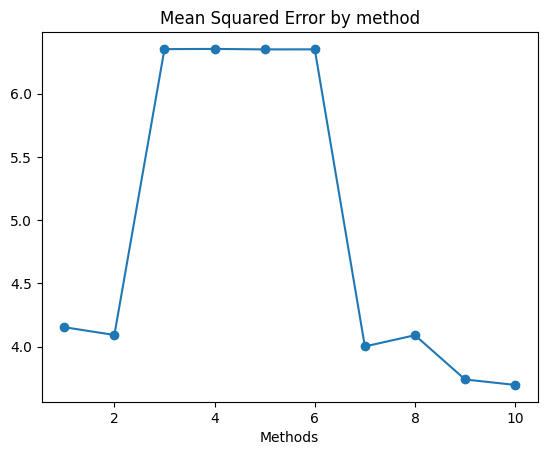

In [18]:
plt.plot(list(range(1,len(MSE)+1)), MSE, marker="o")
plt.title("Mean Squared Error by method")
plt.xlabel("Methods")